# Model performance analysis

## Load data & models

In [2]:
import functions_model_analysis as f
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MultipleLocator

import sys
sys.path.append("../AWS_Scripts/")

import functions_model_analysis as ff

In [6]:
date_from = "2019-08-01"
#date_to = "2019-08-14"
date_to = "2019-08-02"
path = r"../Data/combined/dataframe_extended/"
data = f.import_data(date_from=date_from, date_to=date_to, df_path=path, predict_only=False)
data = f.data_normalization(data)

100%|██████████| 2/2 [00:08<00:00,  4.06s/it]

Not applicable for feature'mw_value'.
Not applicable for feature'col'.
Not applicable for feature'row'.
Not applicable for feature'mw_value_yesterday'.


In [7]:
LinReg = f.load_object('LinearRegression')
LinReg_noXY = f.load_object('LinearRegression_NoXY')
RigdeReg = f.load_object('RidgeRegression')
LassoReg = f.load_object('LassoRegression')
ElasticNetReg = f.load_object('ElasticNetRegression')
RandomForest = f.load_object('RandomForest')
GradientBoosting = f.load_object('XGBoost')

In [8]:
model_list = [LassoReg , GradientBoosting, RandomForest] #, LassoReg, ElasticNetReg, RandomForest, GradientBoosting] # LinReg_noXY

## Analysis

### Model performance table

In [9]:
table = f.model_comparison_table(model_list).reset_index()
table[table['Set']=='Test']

,Model,Set,RMSE,RMSE_std,R2,R2_std
1,LassoRegression,Test,0.179125,0.016700,0.100123,0.084724
3,XGBoost,Test,0.188516,0.032070,-0.012913,0.300837
5,RandomForest,Test,0.197773,0.030502,-0.101216,0.246953


### Mean error plot for all models

In [10]:
df_ = f.mean_predict(LinReg, data)[['opt_value']]

bin_range = (df_['opt_value'].min(), df_['opt_value'].max())
bin_width = 0.1
bin_edges = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)
bin_labels = np.arange(0.05, bin_edges[-1]+0.05, 0.1)


In [11]:
mean_error_list = []

first = True
for model in model_list:
    df = f.mean_predict(model, data)[['row', 'col', 'error_prediction', 'opt_value']]
    df['value_bin'] = pd.cut(df['opt_value'], bins=bin_edges, labels=False)  
    mean_error = df.groupby('value_bin')['error_prediction'].mean()
    del df
    mean_error_list.append(mean_error)

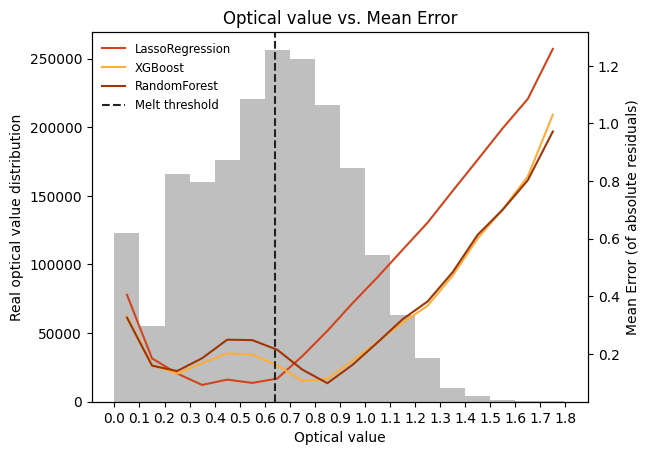

In [12]:
colors = ['#d4441c', '#fead3a',  '#9c3605']

fig, ax = plt.subplots()
ax.hist(df_['opt_value'], bins=bin_edges, color='gray', alpha=0.5)
ax.xaxis.set_major_locator(MultipleLocator(0.1))

ax2 = ax.twinx()
for i in range(len(mean_error_list)):
    ax2.plot(bin_labels, mean_error_list[i].values, label=model_list[i].name, color=colors[i])

ax2.axvline(x=0.64, color='#222222', linestyle='--', label = 'Melt threshold')
ax.set_xlabel('Optical value')
ax.set_ylabel('Real optical value distribution')
ax2.set_ylabel('Mean Error (of absolute residuals)')
ax.set_title('Optical value vs. Mean Error')
legend = ax2.legend(loc='upper left', fontsize='small')
legend.get_frame().set_alpha(0.0)
plt.show()

### Residual analysis

In [ ]:
# sample 50 % of data for plot bc this is tooooo much

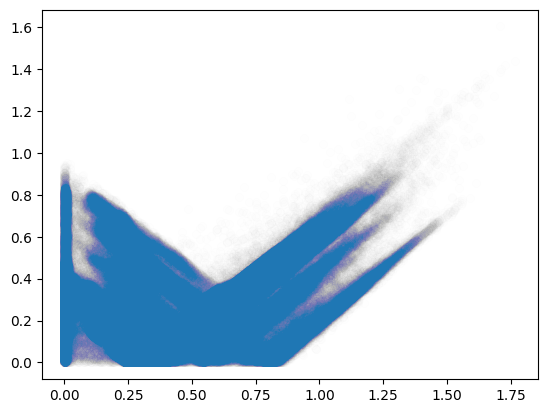

In [16]:
plt.scatter(data_predicted['opt_value'], data_predicted['error_prediction'], alpha = 0.005)

In [14]:
pred = f.mean_predict(LinReg, data)

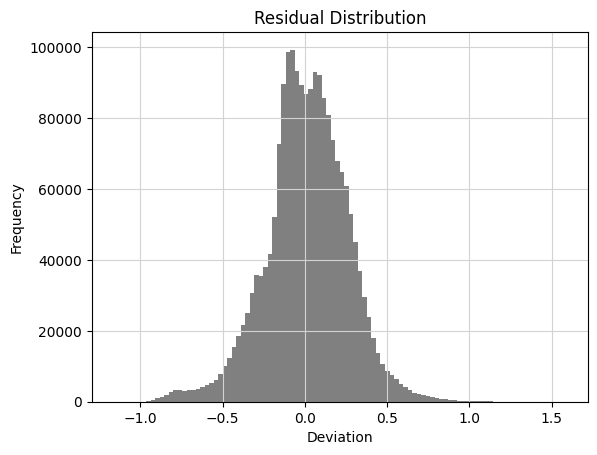

In [15]:

fig, ax = plt.subplots()
data = pred['error_prediction2']
ax.hist(data, bins=100, color='grey')
ax.grid(color='lightgray')
ax.set_xlabel('Deviation')
ax.set_ylabel('Frequency')
plt.title('Residual Distribution')
plt.show()

In [20]:
sampled_df = pred.sample(frac=0.5, random_state=1)

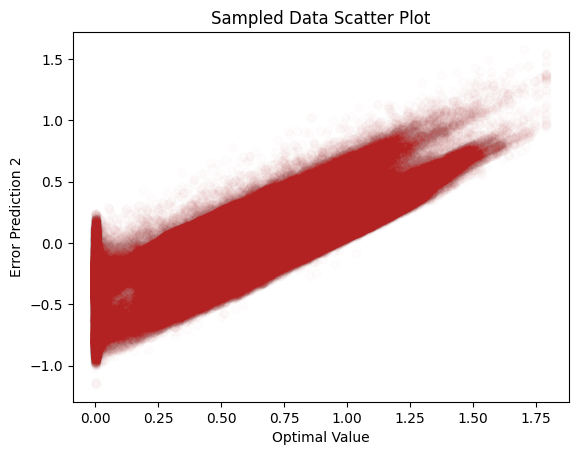

In [21]:
# firebrick distribution
import matplotlib.pyplot as plt

# Create a Figure and Axes object
fig, ax = plt.subplots()

# Plot the scatter plot
ax.scatter(sampled_df['opt_value'], sampled_df['error_prediction2'], alpha=0.01, color='firebrick')

# Set labels and title
ax.set_xlabel('Optimal Value')
ax.set_ylabel('Error Prediction 2')
ax.set_title('Sampled Data Scatter Plot')

# Display the plot
plt.show()


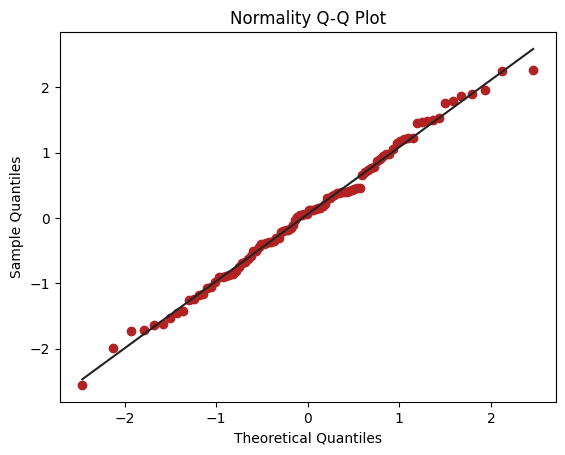

In [18]:

import scipy.stats as stats
import numpy as np

# Generate random data
np.random.seed(0)
data = np.random.normal(loc=0, scale=1, size=100)
#data = pred['error_prediction2']

# Create a Normality Q-Q plot
fig, ax = plt.subplots()
stats.probplot(data, plot=ax, fit=True)

ax.get_lines()[0].set_color('firebrick')
ax.get_lines()[1].set_color('#222222')


# Set labels and title
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')
ax.set_title('Normality Q-Q Plot')

plt.show()

### Other plots

#### heat

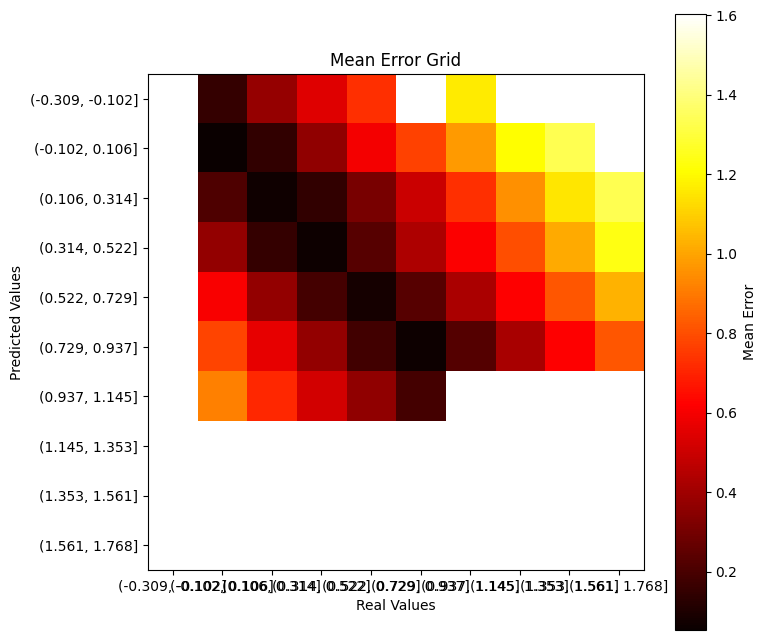

In [31]:
df = data_predicted

# Define the number of bins
num_bins = 10

# Calculate the bin edges for real and predicted values
min_value = min(df['opt_value'].min(), df['mean_prediction'].min())
max_value = max(df['opt_value'].max(), df['mean_prediction'].max())
bin_edges = np.linspace(min_value, max_value, num=num_bins+1)

# Bin the real and predicted values using the same bin edges
real_bins = pd.cut(df['opt_value'], bins=bin_edges)
pred_bins = pd.cut(df['mean_prediction'], bins=bin_edges)

# Group the data by the bin ranges and calculate the mean error for each group
mean_error = df.groupby([real_bins, pred_bins])['error_prediction'].mean().unstack().T

# Create the heatmap grid
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(mean_error.values, cmap='hot')

# Set x and y axis labels
ax.set_xlabel('Real Values')
ax.set_ylabel('Predicted Values')

# Set x and y axis tick labels
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(mean_error.columns)
ax.set_yticklabels(mean_error.index)

# Set colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Mean Error')

# Show the plot
plt.title('Mean Error Grid')
plt.show()


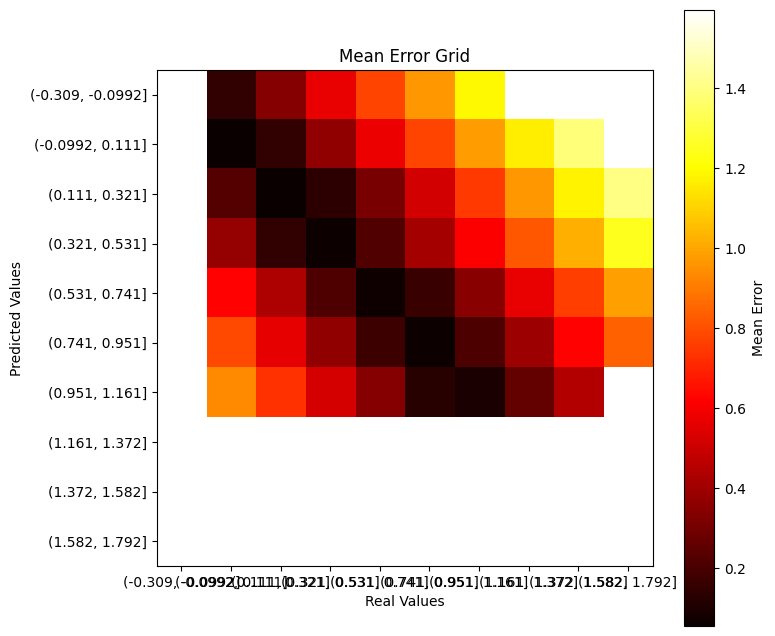

In [11]:
df = data_predicted

# Define the number of bins
num_bins = 10

# Calculate the bin edges for real and predicted values
min_value = min(df['opt_value'].min(), df['mean_prediction'].min())
max_value = max(df['opt_value'].max(), df['mean_prediction'].max())
bin_edges = np.linspace(min_value, max_value, num=num_bins+1)

# Bin the real and predicted values using the same bin edges
real_bins = pd.cut(df['opt_value'], bins=bin_edges)
pred_bins = pd.cut(df['mean_prediction'], bins=bin_edges)

# Group the data by the bin ranges and calculate the mean error for each group
mean_error = df.groupby([real_bins, pred_bins])['error_prediction'].mean().unstack().T

# Create the heatmap grid
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(mean_error.values, cmap='hot')

# Set x and y axis labels
ax.set_xlabel('Real Values')
ax.set_ylabel('Predicted Values')

# Set x and y axis tick labels
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(mean_error.columns)
ax.set_yticklabels(mean_error.index)

# Set colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Mean Error')

# Show the plot
plt.title('Mean Error Grid')
plt.show()


#### real vs pred

In [12]:
# # https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
# from matplotlib import cm
# from matplotlib.colors import Normalize 
# from scipy.interpolate import interpn

# def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
#     """
#     Scatter plot colored by 2d histogram
#     """
#     if ax is None :
#         fig , ax = plt.subplots()
#     data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
#     z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

#     #To be sure to plot all data
#     z[np.where(np.isnan(z))] = 0.0

#     # Sort the points by density, so that the densest points are plotted last
#     if sort :
#         # idx = z.argsort()
#         # x, y, z = x[idx], y[idx], z[idx]

#         idx = np.argsort(z)
#         x, y, z = np.array(x)[idx], np.array(y)[idx], np.array(z)[idx]


#     sc = ax.scatter( x, y, c=z, cmap ='YlOrBr_r' , **kwargs )
#     ax.set_xlabel('real value')
#     ax.set_ylabel('predicted value')
#     ax.set_title('Real vs. Predicted Values')

#     # Find the range of data
#     data_min = min(x) #min(min(x), min(y))
#     data_max = max(y) # max(max(x), max(y))

#     # Adding the line of exact match
#     lin = ax.plot([data_min, data_max], [data_min, data_max], color='black', linestyle='--')

#     norm = Normalize(vmin = np.min(z), vmax = np.max(z))
#     cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = 'YlOrBr_r'), ax=ax)
#     cbar.ax.set_ylabel('Density')

#     return ax


In [7]:
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib


# import numpy as np
# import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interpn

def density_scatter(x, y, ax=None, sort=True, bins=20, bin_width=0.25, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None:
        fig, ax = plt.subplots()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])), data, np.vstack([x, y]).T,
                method="splinef2d", bounds_error=False)

    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = np.argsort(z)
        x, y, z = np.array(x)[idx], np.array(y)[idx], np.array(z)[idx]

    sc = ax.scatter(x, y, c=z, cmap='YlOrBr_r', **kwargs)
    ax.set_xlabel('real value')
    ax.set_ylabel('predicted value')
    ax.set_title('Real vs. Predicted Values')

    # Find the range of data
    data_min = min(x)
    data_max = max(y)

    # # Adding the line of exact match
    # lin = ax.plot([data_min, data_max], [data_min, data_max], color='black', linestyle='--')

    # Calculate average predicted value per bin of real value
    bin_edges = np.arange(min(x), max(x) + bin_width, bin_width)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    predicted_avg = [np.mean(y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])]) for i in range(len(bin_centers))]

    # Plot line with average predicted value per bin
    line = ax.plot(bin_centers, predicted_avg, color='#222222', linestyle='--', linewidth=2, label='Average Predicted Value')

    # Colorbar and normalization
    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='YlOrBr_r'), ax=ax)
    cbar.ax.set_ylabel('Density')

    # Add legend
    # handles, labels = ax.get_legend_handles_labels()
    # handles.extend(line)
    # labels.extend([h.get_label() for h in line])
    # ax.legend(handles, labels)
    # Add legend
    ax.legend([line[0]], ['Average Predicted Value'])

    return ax


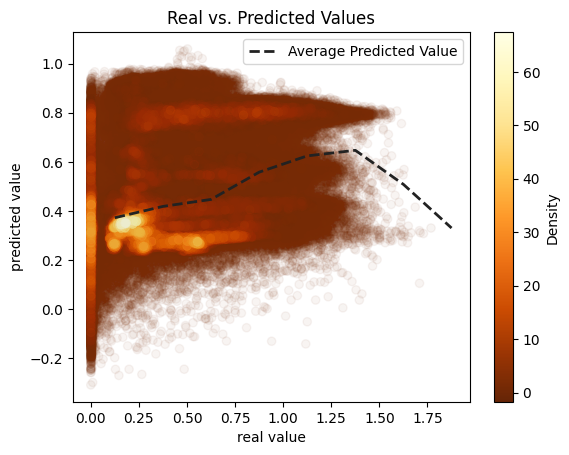

In [79]:
df = data_predicted
x=df['opt_value']
y=df['mean_prediction']

density_scatter( list(x) , list(y), ax = None, sort = True, bins = 2000, alpha = 0.05); 

In [8]:
df = data_predicted[data_predicted['opt_value'] >0]

/mnt/c/Users/linas/OneDrive/Documents/ITU/Semester3/RP_Greenland/RP_Greenland/.venv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/mnt/c/Users/linas/OneDrive/Documents/ITU/Semester3/RP_Greenland/RP_Greenland/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


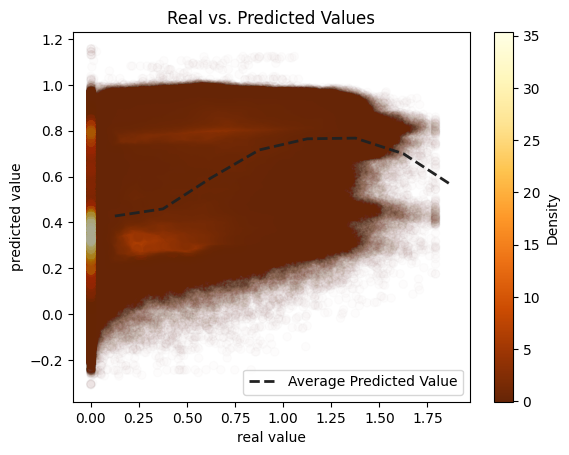

In [9]:
# 14 days:

#df = data_predicted
x=df['opt_value']
y=df['mean_prediction']

density_scatter( list(x) , list(y), ax = None, sort = True, bins = 1000, alpha = 0.01); 

In [ ]:
# fix vedran report issues
# redo sketches
# fix residuals and do some residual plots
# shap?
# do the pred vs real plots for all models??!!
# make feature importance prettier to put plot in report
# put result table in report
# fix up the opt val vs mean error size and error count (mean line on top of histogram)

# area analysis:
# compare rmse north and south
# look at area around melt?, calculate smaller area rmse and compare to a mean opt value. 
# put all plots in report
# 